# Ensembles

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más)

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO


In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/test_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Hagamos tokenize sobre el texto

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

In [7]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

2019-02-20 14:34:11,164 INFO: char embedding size: 2637
2019-02-20 14:34:12,214 INFO: word embedding size: 185214
2019-02-20 14:34:22,553 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(185214, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2637, 50, padding_idx=2634)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

In [9]:
from keras.models import Model
from keras.layers import Concatenate, Dense, CuDNNLSTM
from keras.optimizers import Adam
from keras.utils import plot_model
from hate.nn import CharModel, ElmoModel, BowModel, MergeModel

dropout = [0.80, 0.55]

char_model = CharModel(max_charlen=140, vocab_size=200, recursive_class=CuDNNLSTM, dropout=dropout)
elmo_model = ElmoModel(50, embedder=e, recursive_class=CuDNNLSTM, dropout=dropout)
bow_model = BowModel(
    num_words=5500, vectorize_args={"max_df":0.65, "min_df": 0.00075}, dropout=dropout
)

merge_model = MergeModel([char_model, elmo_model, bow_model])


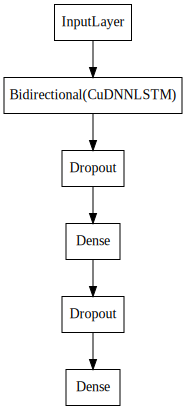

In [26]:
from IPython.display import Image, SVG


plot_model(elmo_model, to_file='elmo_model.pdf', show_layer_names=False)
SVG('elmo_model.svg')

In [14]:
X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/ensemble_16.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15)
history = merge_model.fit(X_train, y_train, callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev), epochs=300, batch_size=48)


2019-01-20 10:13:51,076 INFO: 71 batches, avg len: 52.0
2019-01-20 10:13:54,634 INFO: Finished 1000 sentences.
2019-01-20 10:13:58,077 INFO: Finished 2000 sentences.
2019-01-20 10:14:01,249 INFO: Finished 3000 sentences.
2019-01-20 10:14:04,646 INFO: Finished 4000 sentences.
2019-01-20 10:14:11,581 INFO: 8 batches, avg len: 52.0


Train on 4500 samples, validate on 500 samples
Epoch 1/300
4500/4500 [==============================] - 5s 1ms/step - loss: 0.7031 - acc: 0.5627 - val_loss: 0.6565 - val_acc: 0.6540

Epoch 00001: val_acc improved from -inf to 0.65400, saving model to /tmp/ensemble_16.h5
Epoch 2/300
4500/4500 [==============================] - 3s 668us/step - loss: 0.6511 - acc: 0.6187 - val_loss: 0.6320 - val_acc: 0.6660

Epoch 00002: val_acc improved from 0.65400 to 0.66600, saving model to /tmp/ensemble_16.h5
Epoch 3/300
4500/4500 [==============================] - 3s 679us/step - loss: 0.6140 - acc: 0.6798 - val_loss: 0.6013 - val_acc: 0.6880

Epoch 00003: val_acc improved from 0.66600 to 0.68800, saving model to /tmp/ensemble_16.h5
Epoch 4/300
4500/4500 [==============================] - 3s 679us/step - loss: 0.5814 - acc: 0.7036 - val_loss: 0.5738 - val_acc: 0.7260

Epoch 00004: val_acc improved from 0.68800 to 0.72600, saving model to /tmp/ensemble_16.h5
Epoch 5/300
4500/4500 [===================

In [16]:
from hate.utils import print_evaluation

merge_model.load_weights(checkpointer.filepath)


print_evaluation(merge_model, X_dev, y_dev)

2019-01-20 10:18:31,817 INFO: 8 batches, avg len: 52.0


500/500 [==============================] - 0s 427us/step


2019-01-20 10:18:35,490 INFO: 8 batches, avg len: 52.0


Loss        : 0.4168
Accuracy    : 0.8220
Precision   : 0.8122
Recall      : 0.7793
F1          : 0.7954


In [18]:
merge_model.save_weights("../../../models/nn/ensemble_16.h5")

## Error Analysis

Vamos a ver los tweets con mayores errores

In [39]:
df_dev["proba"] = model.predict(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 41
Falsos positivos: 35


,pred_true,pred_false
real,,
hs=1,181,41
hs=0,35,243


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [40]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.002940
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.014165
23716,"- El otro día me comí a Laura es muy fácil que guarra jajajaja - Laura también te comió a ti entonces tú eres igual de guarro e igual de fácil. - Puto feminazi putas modas eres feminista solo para ligar bien queda gilipollas - em, ok",0.014915
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.020792
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.033408
20711,@lopezdoriga eso es culpa de los gobiernos corruptos que tienen arreglos con esta escoria. Ojalá se muera la perra esa...,0.046482
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.056424
21887,"@A3Noticias Esta tiene que ser una 'fake new' porque las mujeres son siempre las víctimas, no las hijas de puta maltratadoras. Eso o el chaval es un machista que se lo ha merecido (machete al machote).",0.082768
20213,"@britneyspears Perra te lo mereces, esa presentación de WORK BICTH estuvo a tu altura, por fin le hiciste justicia a la canción y al álbum Britney Jean al presentar la canción en un programa de TV luciendo hermosa, acuerpada y subliminal",0.101024


¿Cómo los tokenizamos?

In [41]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Falsos positivos

In [42]:
pd.set_option('max_colwidth', 300)
false_positives[["text", "proba"]]

,text,proba
id,,
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.985307
21892,@saancisco Callate puta tu eres el traidor.,0.983387
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.981542
23320,@HenriFalconLara No digas nada que tú eres cómplice de lo que está pasando... y recuerda seguirás siendo la perra más perra de Venezuela,0.981242
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.976880
23565,La solución no es darle papeles a todos. Es exigir a nuestro gobierno q no fabrique y venda armas a los gobiernos subsaharianos para que estos no masacren y acorralen a su población haciendo q quieran venir aquí x lo civil o criminal. Desesperación y supervivencia pura.,0.963778
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.951528
22115,"Una chica no es una guarra, una zorra, una puta, una buscan por su manera de vestir.",0.944448
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.943650


# Conclusiones

Sirvió mejorar el preprocesamiento y el ensamble!!!. Quedamos en pérdida ~0.39
